In [2]:
# set up things
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from __future__ import print_function

from siphon.catalog import TDSCatalog
from siphon.http_util import session_manager

In [2]:
cat = TDSCatalog('http://thredds.cma.gov.cn/thredds/catalog.xml')
print(list(cat.catalog_refs))

/home/kan-dai/anaconda3/lib/python3.7/site-packages/siphon/catalog.py:268: UserWarning: URL http://thredds.cma.gov.cn/thredds/catalog.html returned HTML. Changing to: http://thredds.cma.gov.cn/thredds/catalog.xml
  new_url))


['GRAPES-Global Model Data', 'GRAPES-Meso Model Data', 'GRAPES-Meso Model (3KM) Data', 'GRAPES-RUC Model Data', 'T639 Deterministic Model Data', 'WRF ADAS Real Time System (SHANGHAI) Model Data', 'RMAPS (BEIJING) Model Data', 'Guangzhou Meso Model Data', 'CMA Meso Models Data', 'ECMWF Main High Resolution Model Products (C1D)', 'ECMWF Global Wave Model Data (C2P)', 'ECMWF Ensemble Model Products (C3E)', 'ECMWF Extreme Forecast Index (EFI) Products (C3Y_EFI)', 'ECMWF Shift Of Tails (SOT) Products (C3Y_SOT)', 'ECMWF C3Y ISOBARIC ES/EP Products (C3Y_ISOBARIC)', 'ECMWF Monthly Forecast Real Time Atmospheric Data (C7F)', 'ECMWF Monthly Forecast Hindcast Atmospheric Data (C7H)', 'Global Forecast System (GFS) 0p5deg', 'Global Forecast System (GFS) 0p5deg  Analysis', 'Germany Global Spectral Model', 'JMA Global Spectral Model', 'Case Data GRAPES_Global', 'Case Data ECMWF_C1D', 'T3E Model Testing', 'Information data']


In [2]:
import xarray as xr

In [3]:
%%time
f = xr.open_dataset('http://thredds.cma.gov.cn/thredds/dodsC/nwp/ECMWF/C1DI/ecmwf_deterministic_isobaric-2020020600/GC')

CPU times: user 78 ms, sys: 19.7 ms, total: 97.7 ms
Wall time: 15.1 s


In [4]:
f

<xarray.Dataset>
Dimensions:                       (isobaric: 19, lat: 281, lon: 361, reftime: 1, time: 53)
Coordinates:
  * lat                           (lat) float32 60.000004 ... -9.999996
  * lon                           (lon) float32 60.000004 60.250004 ... 150.0
  * reftime                       (reftime) datetime64[ns] 2020-02-06
  * time                          (time) datetime64[ns] 2020-02-06 ... 2020-02-16
  * isobaric                      (isobaric) float32 10.0 20.0 ... 950.0 1000.0
Data variables:
    reftime_ISO                   (reftime) |S64 ...
    Temperature_isobaric          (time, isobaric, lat, lon) float32 ...
    U_component_of_wind_isobaric  (time, isobaric, lat, lon) float32 ...
    V_component_of_wind_isobaric  (time, isobaric, lat, lon) float32 ...
    Specific_humidity_isobaric    (time, isobaric, lat, lon) float32 ...
    Vertical_velocity_isobaric    (time, isobaric, lat, lon) float32 ...
    Divergence_isobaric           (time, isobaric, lat, lon) float32 ...
    Geopotential_Height_isobaric  (time, isobaric, lat, lon) float32 ...
    Relative_humidity_isobaric    (time, isobaric, lat, lon) float32 ...
    Potential_vorticity_isobaric  (time, isobaric, lat, lon) float32 ...
Attributes:
    Originating_or_generating_Center:     European Centre for Medium Range We...
    Originating_or_generating_Subcenter:  0
    GRIB_table_version:                   0,128
    Conventions:                          CF-1.6
    history:                              Read using CDM IOSP GribCollection v2
    featureType:                          GRID
    file_format:                          GRIB-1
    _CoordSysBuilder:                     ucar.nc2.dataset.conv.CF1Convention

CPU times: user 80.5 ms, sys: 11.7 ms, total: 92.2 ms
Wall time: 28.2 s


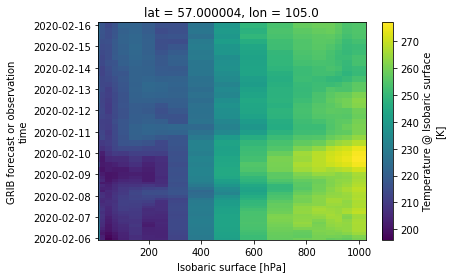

In [8]:
%%time
f.Temperature_isobaric.isel(lat=12, lon=180).plot()

CPU times: user 33.8 ms, sys: 3.85 ms, total: 37.7 ms
Wall time: 3.84 s


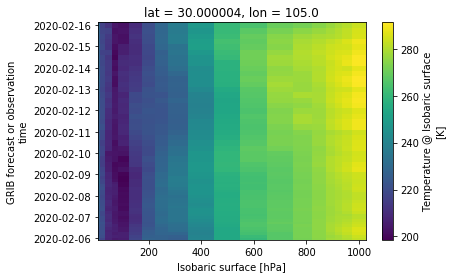

In [9]:
%%time
f.Temperature_isobaric.isel(lat=120, lon=180).plot()

In [30]:
import json
from datetime import datetime, timedelta
import urllib3
import numpy as np
import pandas as pd
import xarray as xr
from nmc_met_io.retrieve_cimiss_server import get_http_result

In [31]:
def cimiss_model_by_time(init_time_str="2020020600",
                         data_code='NAFP_FOR_FTM_HIGH_EC_ANEA',
                         fcst_level=1000, minVT=0, maxVT=84, 
                         latLons="32.90/116.40", fcst_ele="TEM"):
    """
    Retrieve grid data from CIMISS service.

    :param init_time_str: model run time, like "2016081712"
    :param limit: [min_lat, min_lon, max_lat, max_lon]
    :param data_code: MUSIC data code, default is "NAFP_FOR_FTM_HIGH_EC_GLB"
    :param fcst_level: vertical level, default is 0.
    :param valid_time: forecast element, default is 2m temperature "TEF2"
    :param fcst_ele: forecast hour, default is 0
    :return:
    """

    # set retrieve parameters
    params = {'dataCode': data_code,
              'time': init_time_str + '0000',
              'fcstLevel': '{:d}'.format(fcst_level),
              'minVT': '{:d}'.format(minVT),
              'maxVT': '{:d}'.format(maxVT),
              'latLons': latLons,
              'fcstEle': fcst_ele}
    interface_id = 'getNafpEleAtPointByTimeAndLevelAndValidtimeRange'


    # retrieve data contents
    contents = get_http_result(interface_id, params)
    if contents is None:
        return None
    contents = json.loads(contents.decode('utf-8'))
    if contents['returnCode'] != '0':
        return None
    
    return contents

In [32]:
%%time
contents = cimiss_model_by_time()

CPU times: user 4.66 ms, sys: 241 µs, total: 4.9 ms
Wall time: 4.47 s


In [33]:
print(contents)

{'returnCode': '0', 'returnMessage': 'Call Succeed', 'rowCount': '27', 'colCount': '4', 'requestParams': 'time=20200206000000&fcstele=TEM&maxvt=84&datacode=NAFP_FOR_FTM_HIGH_EC_ANEA&fcstlevel=1000&minvt=0&latlons=32.90/116.40', 'requestTime': '2020-02-06 14:42:27', 'responseTime': '2020-02-06 14:42:28', 'takeTime': '0.957', 'fieldNames': '纬度 经度 预报时效 温度', 'fieldUnits': '- - - K', 'DS': [{'Lat': '32.9', 'Lon': '116.4', 'Validtime': '20200206000000', 'TEM': '272.8858'}, {'Lat': '32.9', 'Lon': '116.4', 'Validtime': '20200206030000', 'TEM': '273.29004'}, {'Lat': '32.9', 'Lon': '116.4', 'Validtime': '20200206060000', 'TEM': '274.29462'}, {'Lat': '32.9', 'Lon': '116.4', 'Validtime': '20200206090000', 'TEM': '275.02625'}, {'Lat': '32.9', 'Lon': '116.4', 'Validtime': '20200206120000', 'TEM': '274.93832'}, {'Lat': '32.9', 'Lon': '116.4', 'Validtime': '20200206150000', 'TEM': '274.67535'}, {'Lat': '32.9', 'Lon': '116.4', 'Validtime': '20200206180000', 'TEM': '274.267'}, {'Lat': '32.9', 'Lon': '11

In [35]:
contents.keys()

dict_keys(['returnCode', 'returnMessage', 'rowCount', 'colCount', 'requestParams', 'requestTime', 'responseTime', 'takeTime', 'fieldNames', 'fieldUnits', 'DS'])

In [37]:
data = contents['DS']

In [39]:
pd.DataFrame(data)

,Lat,Lon,Validtime,TEM
0,32.9,116.4,20200206000000,272.8858
1,32.9,116.4,20200206030000,273.29004
2,32.9,116.4,20200206060000,274.29462
3,32.9,116.4,20200206090000,275.02625
4,32.9,116.4,20200206120000,274.93832
5,32.9,116.4,20200206150000,274.67535
6,32.9,116.4,20200206180000,274.267
7,32.9,116.4,20200206210000,273.8404
8,32.9,116.4,20200207000000,273.70398
9,32.9,116.4,20200207030000,275.4469


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from nmc_met_io.retrieve_cimiss_server import cimiss_model_by_piont_levels

In [6]:
%%time
fcst_levels=[1000, 950, 925, 900, 850, 800, 700, 600, 500, 400, 300, 250, 200]
time_range = [0, 120]
point = "32.90/114.40"
temperature = cimiss_model_by_piont_levels("2020020600", fcst_levels=fcst_levels, time_range=time_range, point=point, fcst_ele="TEM")
uwind = cimiss_model_by_piont_levels("2020020600", fcst_levels=fcst_levels, time_range=time_range, point=point, fcst_ele="WIU")
vwind = cimiss_model_by_piont_levels("2020020600", fcst_levels=fcst_levels, time_range=time_range, point=point, fcst_ele="WIV")
rhu = cimiss_model_by_piont_levels("2020020600", fcst_levels=fcst_levels, time_range=time_range, point=point, fcst_ele="RHU")

CPU times: user 697 ms, sys: 7.67 ms, total: 704 ms
Wall time: 1min 32s


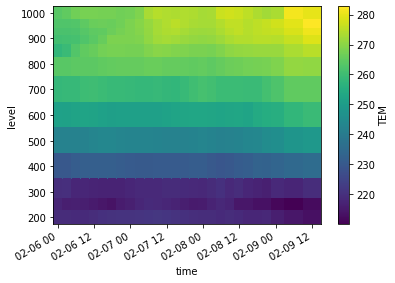

In [3]:
temperature.plot(x="time", y="level")

In [4]:
temperature

<xarray.DataArray 'TEM' (time: 27, level: 13)>
array([[263.8233 , 262.64276, 261.9038 , 260.7968 , 258.06448, 263.74945,
        258.45642, 251.53233, 241.94682, 229.93375, 219.48846, 217.68265,
        218.89677],
       [264.91504, 262.68018, 261.88614, 260.91492, 259.3186 , 263.85794,
        258.7077 , 251.80583, 242.0238 , 229.93423, 219.77937, 216.13647,
        219.01935],
       [266.88837, 263.1657 , 262.1723 , 261.37817, 263.14276, 264.36057,
        258.8974 , 252.26547, 241.88982, 231.14833, 217.91379, 216.38295,
        218.76479],
       [267.8075 , 264.85162, 263.57538, 262.72726, 264.99158, 264.4099 ,
        259.89874, 252.51857, 242.31119, 231.75558, 217.81389, 216.06998,
        218.62843],
       [267.87582, 266.2129 , 264.84097, 264.21143, 265.76273, 264.32727,
        260.05908, 252.26091, 243.1597 , 231.80922, 217.21323, 215.45015,
        219.29735],
       [267.7066 , 266.32816, 264.94354, 266.01807, 267.16132, 264.91483,
        259.51788, 251.47481, 243.79732, 231.84975, 217.04498, 214.42744,
        220.2671 ],
       [267.4545 , 266.2224 , 266.51428, 268.3579 , 267.8163 , 265.39795,
        258.92902, 250.90523, 243.77065, 231.88841, 216.93843, 213.60007,
        220.41576],
       [267.0279 , 266.95026, 267.7138 , 268.30084, 267.75116, 265.59082,
        258.93622, 251.18744, 243.2605 , 231.16946, 217.16454, 215.55777,
        220.60014],
       [267.20398, 268.33646, 268.50644, 268.3578 , 267.45795, 265.57288,
        258.79974, 251.19116, 242.91776, 230.67987, 217.82135, 216.61823,
        220.8262 ],
       [268.72815, 269.69455, 269.37115, 268.83557, 267.64792, 265.55518,
        258.49094, 251.14641, 242.94655, 230.48781, 218.44485, 217.98036,
        220.99136],
       [273.38287, 271.1619 , 271.10538, 270.67047, 268.97656, 266.2631 ,
        258.43146, 251.16722, 242.83209, 230.5163 , 218.32625, 218.69864,
        221.32698],
       [274.64297, 272.87915, 272.92816, 272.48294, 269.77573, 266.08093,
        258.72266, 251.23946, 242.66814, 230.79022, 218.47284, 218.32628,
        221.47559],
       [274.1031 , 274.24792, 273.9591 , 273.10538, 269.48596, 265.60596,
        258.1611 , 251.91904, 242.39793, 230.67044, 218.96428, 217.99277,
        221.41559],
       [273.90543, 275.1281 , 274.06677, 272.44025, 268.94678, 265.55847,
        257.97736, 252.64818, 242.01752, 230.58589, 218.94432, 217.05441,
        220.8126 ],
       [274.22925, 274.08585, 272.84296, 271.55893, 268.6146 , 265.39618,
        259.04034, 252.72401, 242.18124, 230.71646, 218.76956, 216.23735,
        220.27837],
       [273.82043, 273.2165 , 272.00476, 270.89844, 268.24612, 265.14224,
        260.37265, 252.96944, 242.61198, 231.15044, 218.57811, 215.39949,
        219.50705],
       [272.97107, 272.87485, 271.75784, 270.76917, 268.04077, 265.201  ,
        261.3734 , 253.07689, 243.0642 , 231.29501, 218.21841, 215.58182,
        219.43788],
       [273.2176 , 273.09705, 272.24774, 270.9646 , 267.92203, 264.8426 ,
        260.67078, 252.89233, 242.61548, 230.23543, 219.07254, 217.00021,
        219.4175 ],
       [276.95276, 274.4817 , 273.49884, 272.1964 , 269.0863 , 265.7353 ,
        259.72076, 252.66624, 241.83176, 229.43604, 220.14458, 218.13716,
        218.80904],
       [277.5004 , 275.93884, 274.82208, 273.4953 , 270.35693, 266.40863,
        259.71838, 252.87857, 242.4461 , 229.94208, 218.58476, 217.46324,
        219.22818],
       [276.94977, 275.8906 , 275.69434, 274.41278, 270.98383, 266.79868,
        259.6302 , 252.96297, 242.64221, 231.07837, 219.26062, 214.49426,
        218.74942],
       [275.61404, 274.67874, 274.6798 , 274.497  , 271.199  , 267.40622,
        259.48   , 252.64163, 243.4228 , 231.46153, 217.88437, 214.42407,
        217.77576],
       [273.80054, 275.42877, 275.59814, 274.8513 , 271.57724, 267.54877,
        259.3683 , 254.2949 , 243.84767, 232.81688, 217.07835, 213.42157,
        217.95366],
       [272.6599 , 276.48383, 276.16217, 274.94397, 271.44763, 267.89075,
        261.025

In [21]:
from nmc_met_io.config import get_config_dir

In [22]:
rc = get_config_dir() / "config.ini"

In [24]:
print(rc)

/home/kan-dai/.nmcdev/config.ini


In [27]:
%%time
from datetime import datetime, timedelta, date
my_date = date.today() # if date is 01/01/2018
year, week_num, day_of_week = my_date.isocalendar()
print("Week #" + str(week_num) + " of year " + str(year))

Week #6 of year 2020
CPU times: user 121 µs, sys: 19 µs, total: 140 µs
Wall time: 91.8 µs


In [34]:
get_config_dir() / "cache" / date.today().strftime("%Y%U")

PosixPath('/home/kan-dai/.nmcdev/cache/202005')

In [1]:
import numpy as np
from nmc_met_io.retrieve_micaps_server import get_model_grid, get_model_3D_grids

In [2]:
%%time
directory = "ECMWF_HR/TMP"
levels = [1000, 950, 925, 900, 850, 800, 700, 600, 500, 400, 300, 250, 200, 100]
fhours = np.arange(0, 75, 3)
filenames = ["20020620."+str(fhour).zfill(3) for fhour in fhours]
data = get_model_3D_grids(directory, filenames, levels)

Get data: 100%|██████████| 25/25 [00:12<00:00,  1.99it/s]

CPU times: user 2.35 s, sys: 468 ms, total: 2.81 s
Wall time: 12.6 s


In [4]:
%%time
directory = "ECMWF_HR/TMP"
levels = [1000, 950, 925, 900, 850, 800, 700, 600, 500, 400, 300, 250, 200, 100]
fhours = np.arange(0, 75, 3)
filenames = ["20020620."+str(fhour).zfill(3) for fhour in fhours]
data = get_model_3D_grids(directory, filenames, levels, pbar=False)

CPU times: user 352 ms, sys: 42.9 ms, total: 395 ms
Wall time: 394 ms


In [4]:
from nmc_met_io.retrieve_micaps_server import get_model_3D_grids, get_model_vertical_times

In [2]:
directory = "ECMWF_HR/TMP"
levels = [1000, 950, 925, 900, 850, 800, 700, 600, 500, 400, 300, 250, 200, 100]
filenames = ["20021320.024"]
data =  get_model_3D_grids(directory, filenames, levels)

Get data: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


In [5]:
points = {'lon':[116.3833, 110.0], 'lat':[39.9, 32]}
data = get_model_vertical_times(directory, filenames, levels, points)

Get data: 100%|██████████| 1/1 [00:00<00:00, 52.48it/s]


In [6]:
data

<xarray.Dataset>
Dimensions:                  (level: 14, points: 2, time: 1)
Coordinates:
    forecast_reference_time  datetime64[ns] 2020-02-13T20:00:00
  * level                    (level) float64 1e+03 950.0 925.0 ... 200.0 100.0
    forecast_period          (time) float64 24.0
  * time                     (time) datetime64[ns] 2020-02-14T20:00:00
    lon                      (points) float64 116.4 110.0
    lat                      (points) float64 39.9 32.0
Dimensions without coordinates: points
Data variables:
    data                     (time, level, points) float64 -1.855 ... -59.14
Attributes:
    Conventions:  CF-1.6
    Origin:       MICAPS Cassandra Server

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
from nmc_met_io.retrieve_micaps_server import get_fy_awx

In [3]:
directory = "SATELLITE/FY2F/L1/IR1/LAMBERT"
data= get_fy_awx(directory)

In [4]:
data

<xarray.Dataset>
Dimensions:  (lat: 1500, lon: 2000, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2020-02-14T12:00:00
  * lat      (lat) float64 69.97 69.92 69.87 69.82 ... -4.83 -4.88 -4.93 -4.98
  * lon      (lon) float64 50.02 50.07 50.12 50.17 ... 149.8 149.9 149.9 150.0
Data variables:
    image    (time, lat, lon) uint8 234 234 235 235 235 ... 212 213 213 213 213
Attributes:
    Conventions:  CF-1.6
    Origin:       MICAPS Cassandra Server

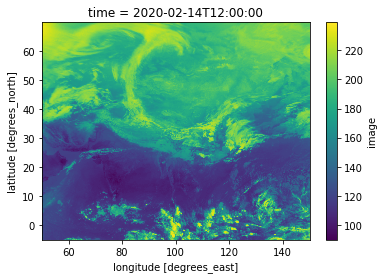

In [5]:
data.image.plot()

In [7]:
pd.DataFrame(info).T

,0
SAT96,b'EIEF1460.AWX'
byteSequence,0
firstClassHeadLength,40
secondClassHeadLength,2112
padDataLength,1848
recordLength,2000
headRecordNumber,3
dataRecordNumber,1500
productCategory,1
compressMethod,0


In [8]:
info['latitudeOfNorth'] - info('latitudeOfSouth')

TypeError: 'numpy.ndarray' object is not callable

In [24]:
lat = (head_info['latitudeOfSouth'][0]/100. + 
       np.arange(head_info['heightOfImage'][0])*head_info['verticalResolution'][0]/100.)

In [4]:
from tqdm import tqdm, tqdm_notebook       # <-- yes
from time import sleep
from IPython.display import clear_output

In [44]:
for i in tqdm(range(20)):  # <-- magic
    for j in range(10):
      sleep(0.01)
for i in tqdm(range(20)):  # <-- magic
    for j in range(10):
      sleep(0.01)
clear_output()
print('test')

test


In [42]:
for i in tqdm_notebook(range(20)):  # <-- magic
    for j in range(10):
      sleep(0.01)
for i in tqdm_notebook(range(20)):  # <-- magic
    for j in range(10):
      sleep(0.01)
clear_output()
print('test')

test


In [14]:
from nmc_met_io.retrieve_micaps_server import get_radar_mosaic

In [15]:
data = get_radar_mosaic("RADARMOSAIC/CREF/")

In [16]:
data

<xarray.Dataset>
Dimensions:  (lat: 4200, lon: 6200, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2020-02-16T09:42:00
  * lat      (lat) float64 12.21 12.22 12.23 12.24 ... 54.17 54.18 54.19 54.2
  * lon      (lon) float64 73.0 73.0 73.01 73.02 ... 135.0 135.0 135.0 135.0
Data variables:
    data     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:  CF-1.6
    Origin:       MICAPS Cassandra Server

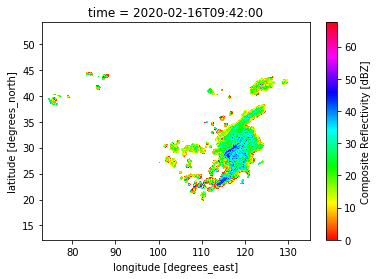

In [18]:
data.data.plot(cmap='hsv')

In [3]:
from nmc_met_io.retrieve_micaps_server import get_tlogp

In [4]:
data = get_tlogp("UPPER_AIR/TLOGP/")

In [5]:
data

,ID,lon,lat,alt,time,p,h,t,td,wind_angle,wind_speed
0,64870,13.570,7.3500,1104.0,2020-02-15 14:00:00,850.0,9999.0,9999.0,9999.0,60.0,11.0
1,64870,13.570,7.3500,1104.0,2020-02-15 14:00:00,700.0,9999.0,9999.0,9999.0,160.0,6.0
2,43413,79.920,8.9800,3.0,2020-02-15 14:00:00,850.0,9999.0,9999.0,9999.0,30.0,6.0
3,48500,99.806,11.8343,4.0,2020-02-15 14:00:00,850.0,9999.0,9999.0,9999.0,180.0,8.0
4,48500,99.806,11.8343,4.0,2020-02-15 14:00:00,850.0,9999.0,9999.0,9999.0,180.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
716,15614,23.380,42.6500,591.0,2020-02-15 14:00:00,19.3,9999.0,9999.0,9999.0,245.0,13.0
717,15614,23.380,42.6500,591.0,2020-02-15 14:00:00,18.8,9999.0,9999.0,9999.0,240.0,14.0
718,15614,23.380,42.6500,591.0,2020-02-15 14:00:00,18.2,9999.0,-57.5,-90.5,9999.0,9999.0
719,15614,23.380,42.6500,591.0,2020-02-15 14:00:00,17.1,9999.0,-55.1,-91.1,9999.0,9999.0


In [6]:
longname = {'CREF': 'Composite Reflectivity', 'QREF': 'Basic Reflectivity',
                        'VIL': 'Vertically Integrated Liquid', 'OHP': 'One Hour Precipitation'}

In [9]:
longname.get('CREF1', 'TEST')

'TEST'

In [25]:
from nmc_met_io.retrieve_micaps_server import get_station_data, get_latest_initTime,get_file_list

In [20]:
data = get_station_data("SURFACE/PLOT_10MIN")

In [21]:
data

,ID,lon,lat,Alt,Relative_humidity,806,Wind_angle_2m_avg,210,Wind_speed_2m_avg,212,...,602,Pressure,414,Rain,1002,Vis_1min,1202,Dewpoint,802,time
0,786444,107.009697,23.463900,350.000000,66.0,False,348.0,False,3.4,False,...,False,997.400024,False,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-15 17:50:00
1,720906,126.753098,45.772800,132.000000,66.0,False,15.0,False,1.5,False,...,False,1012.000000,False,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-15 17:50:00
2,720905,126.542198,45.735600,120.000000,58.0,False,173.0,False,0.6,False,...,False,1012.500000,False,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-15 17:50:00
3,720911,126.571098,46.762798,123.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-15 17:50:00
4,720903,126.631699,45.745800,121.000000,NaN,NaN,137.0,False,1.4,False,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-15 17:50:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45257,720891,127.913597,46.008900,140.500000,NaN,NaN,348.0,False,0.0,False,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-15 17:50:00
45258,786424,107.125298,23.325001,285.000000,65.0,False,43.0,False,3.4,False,...,False,977.799988,True,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-15 17:50:00
45259,720894,127.801903,46.240299,140.000000,63.0,False,215.0,False,1.6,False,...,False,1010.400024,False,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-15 17:50:00
45260,720895,127.813599,46.318600,136.300003,NaN,NaN,297.0,False,4.0,False,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-15 17:50:00


In [23]:
initTime = get_latest_initTime("ECMWF_HR/TMP/850")

In [30]:
files = get_file_list("SURFACE/PLOT_10MIN")

In [34]:
files.sort(reverse=True)

In [32]:
files.sort()

In [36]:
min(len(files), 20)

20

In [221]:
import pandas as pd
import numpy as np
from nmc_met_io.retrieve_cimiss_server import cimiss_obs_by_time_range, cimiss_obs_convert_type, \
    cimiss_obs_by_time_and_id, cimiss_get_obs_latest_time,cimiss_obs_by_time, \
    cimiss_obs_by_time_range_and_id, cimiss_model_by_time, cimiss_model_by_times, \
    cimiss_obs_file_by_time_range, cimiss_obs_grid_by_time, cimiss_obs_grid_by_times, \
    cimiss_analysis_by_time, cimiss_analysis_by_times

In [70]:
time_range = "[20200212000000,20200214000000]"
data_code = "SURF_CHN_MUL_DAY"
sta_levels = "011,012,013"
elements = "Station_Id_C,Station_Name,Datetime,Lat,Lon,PRE_Time_0808"
data = cimiss_obs_by_time_range(time_range, sta_levels=sta_levels,
                                data_code=data_code, elements=elements)

In [85]:
time = cimiss_get_obs_latest_time(latestTime=24)
time

,Datetime
0,20200216020000


In [91]:
sta_levels = None
params = sta_levels if sta_levels is not None else 3

In [122]:
data = cimiss_obs_by_time_range_and_id("[20160801000000,20160802000000]")

In [143]:
data = cimiss_model_by_time("2020021512", data_code="NAFP_FOR_FTM_HIGH_EC_ANEA", fcst_level=850, fcst_ele='TEM', units="C", scale_off=[1.0, -273.15])

In [148]:
data = cimiss_model_by_times("2020021512", valid_times=np.arange(0, 35, 6), data_code="NAFP_FOR_FTM_HIGH_EC_ANEA", fcst_level=850, fcst_ele='TEM', units="C", scale_off=[1.0, -273.15])

NAFP_FOR_FTM_HIGH_EC_ANEA: 100%|██████████| 6/6 [00:01<00:00,  3.25it/s]


In [196]:
times = ["20200208000000", "20200208010000"]
data_code = "SURF_CMPA_FRT_5KM"
data = cimiss_obs_grid_by_times(times, data_code=data_code, fcst_ele="PRE")



SURF_CMPA_FRT_5KM:   0%|          | 0/2 [00:00<?, ?it/s]

SURF_CMPA_FRT_5KM:  50%|█████     | 1/2 [00:01<00:01,  1.11s/it]

SURF_CMPA_FRT_5KM: 100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


In [197]:
data.PRE

<xarray.DataArray 'PRE' (time: 2, lat: 1201, lon: 1401)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 70.0 70.05 70.1 70.15 ... 139.9 139.9 140.0 140.0
  * lat      (lat) float64 0.0 0.05 0.1 0.15 0.2 ... 59.8 59.85 59.9 59.95 60.0
  * time     (time) datetime64[ns] 2020-02-08 2020-02-08T01:00:00
Attributes:
    long_name:  降水量(整个大气层)
    units:      -

In [191]:
time_str = "20200106130000"
data_code = "SURF_CMPA_FRT_5KM"
data = cimiss_obs_grid_by_time(time_str, data_code=data_code, fcst_ele="PRE")

In [192]:
data

<xarray.Dataset>
Dimensions:  (lat: 1201, lon: 1401, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-06T13:00:00
  * lat      (lat) float64 0.0 0.05 0.1 0.15 0.2 ... 59.8 59.85 59.9 59.95 60.0
  * lon      (lon) float64 70.0 70.05 70.1 70.15 ... 139.9 139.9 140.0 140.0
Data variables:
    PRE      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:  CF-1.6
    Origin:       CIMISS Server by MUSIC API

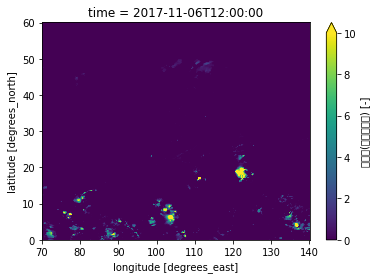

In [162]:
data.PRE.plot(vmin=0, vmax=10)

In [207]:
data = cimiss_analysis_by_time("20200215120000", data_code="NAFP_CLDAS2.0_RT_GRB", fcst_level=2, fcst_ele='TEF2', units="C", scale_off=[1.0, -273.15])

In [211]:
times = ["20200208000000", "20200209000000"]
data_code = "NAFP_CLDAS2.0_RT_GRB"
data = cimiss_analysis_by_times(times, data_code=data_code)



NAFP_CLDAS2.0_RT_GRB:   0%|          | 0/2 [00:00<?, ?it/s]

NAFP_CLDAS2.0_RT_GRB:  50%|█████     | 1/2 [00:03<00:03,  3.36s/it]

NAFP_CLDAS2.0_RT_GRB: 100%|██████████| 2/2 [00:06<00:00,  3.22s/it]


In [214]:
limit = [18, 78, 54, 24]
str(limit)

'[18, 78, 54, 24]'

In [219]:
import os
os.path.join("C:", "daikan", "", "123")

'C:/daikan/123'

In [224]:
data = cimiss_model_by_time("2020021512", data_code="NAFP_FOR_FTM_HIGH_EC_ANEA", 
                            fcst_level=850, fcst_ele='TEM', units="C", scale_off=[1.0, -273.15])

In [225]:
data

<xarray.Dataset>
Dimensions:                  (lat: 281, level: 1, lon: 361, time: 1)
Coordinates:
  * time                     (time) datetime64[ns] 2020-02-15T12:00:00
  * level                    (level) int64 850
  * lat                      (lat) float64 60.0 59.75 59.5 ... -9.5 -9.75 -10.0
  * lon                      (lon) float64 60.0 60.25 60.5 ... 149.5 149.8 150.0
    forecast_reference_time  datetime64[ns] 2020-02-15T12:00:00
    forecast_period          (time) float64 0.0
Data variables:
    TEM                      (time, level, lat, lon) float32 -11.893372 ... 18.716003
Attributes:
    Conventions:  CF-1.6
    Origin:       CIMISS Server by MUSIC API